In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage, elo_save_feature
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys
from joblib import Parallel, delayed

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [2]:
#========================================================================
# hist_regist_termに対するリフトをfeatureとするが、粒度となるhist_regist_termは複数の細かさで作り分ける
# 331, 431: ~2, 24~以外はそのまま
# 331, 431: ~2, 24~以外はそのまま
#========================================================================
col_term = 'hist_regist_term'
fam = 'first_active_month'

# make fam & term group
train_test = utils.read_df_pkl('../input/base_term*0*')[[key, 'first_active_month', target, col_term, 'hist_purchase_date_max']]
train_test['hist_regist_term'] = train_test['hist_regist_term'].map(lambda x:
                                                                    24 if x>=24 else
                                                                    2  if x<=2 else
                                                                    x
                                                                   )
# train_test['hist_regist_term'] = train_test['hist_regist_term'].map(lambda x:
#                                                                     24 if x>=24 else
#                                                                     18 if x>=18 else
#                                                                     15 if x>=15 else
#                                                                     12 if 9<=x and x<=14 else
#                                                                     6 if 6<=x and x<=8  else 
#                                                                     5 if x==5 else
#                                                                     4 if x<=4 else
#                                                                     -1
#                                                                    )


fam_term = train_test[[fam, col_term]].drop_duplicates().sort_values(by=[fam, col_term])
fam_term.reset_index(drop=True, inplace=True)
fam_term['group'] = np.arange(len(fam_term))+1
train_test = train_test.merge(fam_term, on=[fam, col_term], how='inner').set_index(key)

df_hist = utils.read_df_pkl('../input/hist_clean*0*')
df_new = utils.read_df_pkl('../input/new_clean*0*')

df_hist  = utils.reduce_mem_usage(df_hist )
df_new   = utils.reduce_mem_usage(df_new  )

100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Mem. usage decreased to 2554.26 Mb (0.0% reduction)
Mem. usage decreased to 183.47 Mb (0.0% reduction)


In [3]:
df_hist = df_hist.join(train_test[['hist_purchase_date_max', 'hist_regist_term']])
df_new = df_new.join(train_test[['hist_purchase_date_max', 'hist_regist_term']])
auth1 = df_hist[df_hist.authorized_flag==1]
auth0 = df_hist[df_hist.authorized_flag==0]
print(auth1.shape)
print(auth0.shape)

cat1_0 = False
cat1_0 = True
if cat1_0:
    auth1_cat1 = auth1[auth1.category_1==1]
    auth1_cat0 = auth1[auth1.category_1==0]
    auth0_cat1 = auth0[auth0.category_1==1]
    auth0_cat0 = auth0[auth0.category_1==0]
    new_cat1 = df_new[df_new.category_1==1]
    new_cat0 = df_new[df_new.category_1==0]

(26595452, 23)
(2516909, 23)


In [4]:
new_df_list = [df_new, new_cat1, new_cat0]
new_fname_list = ['new_all', 'new_cat1', 'new_cat0']

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

for df, fname in zip(tqdm(new_df_list), new_fname_list):
    
    # new
    df['purchase_date'] = pd.to_datetime( df['purchase_date'])
    df['date_diff'] = (df['hist_purchase_date_max'] - df['purchase_date']).dt.days
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df[f'amount_per_installments'] = df[f'purchase_amount'] / (df[f'installments'] + 1.0)
    
    aggs = {}
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id', 'yyyymmdd']
    
    for col in col_unique:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum', 'min']
    aggs['installments'] = ['mean', 'max']
    aggs['amount_per_installments'] = ['sum']
    aggs['month_lag'] = ['max','mean']
    aggs['month_diff'] = ['mean', 'min']
    aggs['card_id'] = ['size']
    
    df.reset_index(inplace=True)
    
    new_columns = get_new_columns(fname, aggs)
    
    print('Aggregation Start!')
    print(df.shape)
    df_agg = df.groupby(key).agg(aggs)
    df_agg.columns = new_columns
    
    train_test = train_test.join(df_agg)

  0%|          | 0/3 [00:00<?, ?it/s]

Aggregation Start!
(1963031, 27)


 33%|███▎      | 1/3 [00:10<00:21, 10.50s/it]

Aggregation Start!
(63096, 27)


 67%|██████▋   | 2/3 [00:11<00:07,  7.57s/it]

Aggregation Start!
(1899935, 27)


100%|██████████| 3/3 [00:21<00:00,  8.35s/it]


In [2]:
term_name = 'new_regist_term'
term_name = 'hist_regist_term'
group_list = sorted(list(train_test['group'].value_counts().index))

feat_cols = [col for col in train_test if col.count('new_cat')]

lift_list = []
for group in tqdm(group_list):
    
    tmp_list = []
    for col in feat_cols:
        tmp = train_test[train_test['group']==group].reset_index()
        fam_val = tmp[fam].values[0]
        term = tmp[term_name].values[0]
        tmp = tmp[[key, col]]
        # マイナスがあるとリフトがややこしくなるので正規化する
        val_min = tmp[col].min()
        tmp[col] -= val_min + 1
        base_avg = tmp[col].mean()
        tmp.set_index(key, inplace=True)
        tmp[col] /= base_avg
#         tmp.rename(columns={col:f'lift_regist_term{int(term)}_{col}'}, inplace=True)
#         tmp.rename(columns={col:f'lift_group{group}_fam{fam_val}_hist_regist_term{term}_{col}'}, inplace=True)
        tmp.rename(columns={col:f'lift_group_fam_hist_regist_term_{col}'}, inplace=True)
        tmp_list.append(tmp)
    df_term = pd.concat(tmp_list, axis=1)
    lift_list.append(df_term)
    
df_lift = pd.concat(lift_list, axis=0)
print(df_lift.shape)
base = utils.read_df_pkl('../input/base_term*0*').set_index(key)['target'].to_frame()
df_lift = base.join(df_lift)
df_lift.head()

SystemExit: 

In [9]:
# prefix = '331_lgr'
prefix = '431_lgr'

#========================================================================
# Save Feature
elo_save_feature(df_feat=df_lift, prefix=prefix)
#========================================================================
print('Complete!')

Complete!


In [10]:
term_name = 'new_regist_term'
term_name = 'hist_regist_term'
hist_df_list = [auth1_cat1, auth1_cat0, auth0_cat1, auth0_cat0]
hist_fname_list = ['auth1_cat1', 'auth1_cat0', 'auth0_cat1', 'auth0_cat0']

# Train_Test Load
train_test = utils.read_df_pkl('../input/base_term*0*')[[key, 'first_active_month', target, col_term, 'hist_purchase_date_max']]
train_test['hist_regist_term'] = train_test['hist_regist_term'].map(lambda x:
                                                                    24 if x>=24 else
                                                                    2  if x<=2 else
                                                                    x
                                                                   )
fam_term = train_test[[fam, col_term]].drop_duplicates().sort_values(by=[fam, col_term])
fam_term.reset_index(drop=True, inplace=True)
fam_term['group'] = np.arange(len(fam_term))+1
train_test = train_test.merge(fam_term, on=[fam, col_term], how='inner').set_index(key)

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

for df, fname in zip(tqdm(hist_df_list), hist_fname_list):
    
    # new
    df['purchase_date'] = pd.to_datetime( df['purchase_date'])
    df['date_diff'] = (df['hist_purchase_date_max'] - df['purchase_date']).dt.days
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df[f'amount_per_installments'] = df[f'purchase_amount'] / (df[f'installments'] + 1.0)
    
    aggs = {}
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id', 'yyyymmdd']
    
    for col in col_unique:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum', 'min']
    aggs['installments'] = ['mean', 'max']
    aggs['amount_per_installments'] = ['sum']
    aggs['month_lag'] = ['max','mean']
    aggs['month_diff'] = ['mean', 'min']
    aggs['card_id'] = ['size']
    
    df.reset_index(inplace=True)
    
    new_columns = get_new_columns(fname, aggs)
    
    print('Aggregation Start!')
    print(df.shape)
    df_agg = df.groupby(key).agg(aggs)
    df_agg.columns = new_columns
    
    train_test = train_test.join(df_agg)

print('Complete!')

  0%|          | 0/4 [00:00<?, ?it/s]

Aggregation Start!
(1560059, 27)


 25%|██▌       | 1/4 [00:04<00:14,  4.98s/it]

Aggregation Start!
(25035393, 27)


 50%|█████     | 2/4 [01:37<01:02, 31.25s/it]

Aggregation Start!
(523970, 27)


 75%|███████▌  | 3/4 [01:39<00:22, 22.39s/it]

Aggregation Start!
(1992939, 27)


100%|██████████| 4/4 [01:46<00:00, 17.81s/it]

Complete!


In [11]:
# termあたりのliftを計算する
term_name = 'new_regist_term'
term_name = 'hist_regist_term'
# group_list = sorted(list(train_test['group'].value_counts().index))

feat_cols = [col for col in train_test if col.count('auth')]

lift_list = []
for group in tqdm(group_list):
    
    tmp_list = []
    for col in feat_cols:
        tmp = train_test[train_test['group']==group].reset_index()
        fam_val = tmp[fam].values[0]
        term = tmp[term_name].values[0]
        tmp = tmp[[key, col]]
        # マイナスがあるとリフトがややこしくなるので正規化する
        val_min = tmp[col].min()
        tmp[col] -= val_min + 1
        
        base_avg = tmp[col].mean()
        tmp.set_index(key, inplace=True)
        tmp[col] /= base_avg
#         tmp.rename(columns={col:f'lift_regist_term{int(term)}_{col}'}, inplace=True)
#         tmp.rename(columns={col:f'lift_group{group}_fam{fam_val}_hist_regist_term{term}_{col}'}, inplace=True)
        tmp.rename(columns={col:f'lift_group_fam_hist_regist_term_{col}'}, inplace=True)
        tmp_list.append(tmp)
    df_term = pd.concat(tmp_list, axis=1)
    lift_list.append(df_term)
    
df_lift = pd.concat(lift_list, axis=0)
print(df_lift.shape)
base = utils.read_df_pkl('../input/base_term*0*').set_index(key)['target'].to_frame()
df_lift = base.join(df_lift)
df_lift.head()

100%|██████████| 3/3 [00:00<00:00, 51.86it/s]

(325540, 56)


,target,lift_group_fam_hist_regist_term_auth1_cat1_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_cat1_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_cat1_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_cat1_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_cat1_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_cat1_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_cat1_installments_mean,lift_group_fam_hist_regist_term_auth1_cat1_installments_max,lift_group_fam_hist_regist_term_auth1_cat1_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth1_cat1_month_lag_max,lift_group_fam_hist_regist_term_auth1_cat1_month_lag_mean,lift_group_fam_hist_regist_term_auth1_cat1_month_diff_mean,lift_group_fam_hist_regist_term_auth1_cat1_month_diff_min,lift_group_fam_hist_regist_term_auth1_cat1_card_id_size,lift_group_fam_hist_regist_term_auth1_cat0_subsector_id_nunique,lift_group_fam_hist_regist_term_auth1_cat0_merchant_id_nunique,lift_group_fam_hist_regist_term_auth1_cat0_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth1_cat0_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth1_cat0_purchase_amount_sum,lift_group_fam_hist_regist_term_auth1_cat0_purchase_amount_min,lift_group_fam_hist_regist_term_auth1_cat0_installments_mean,lift_group_fam_hist_regist_term_auth1_cat0_installments_max,lift_group_fam_hist_regist_term_auth1_cat0_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth1_cat0_month_lag_max,lift_group_fam_hist_regist_term_auth1_cat0_month_lag_mean,lift_group_fam_hist_regist_term_auth1_cat0_month_diff_mean,lift_group_fam_hist_regist_term_auth1_cat0_month_diff_min,lift_group_fam_hist_regist_term_auth1_cat0_card_id_size,lift_group_fam_hist_regist_term_auth0_cat1_subsector_id_nunique,lift_group_fam_hist_regist_term_auth0_cat1_merchant_id_nunique,lift_group_fam_hist_regist_term_auth0_cat1_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth0_cat1_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth0_cat1_purchase_amount_sum,lift_group_fam_hist_regist_term_auth0_cat1_purchase_amount_min,lift_group_fam_hist_regist_term_auth0_cat1_installments_mean,lift_group_fam_hist_regist_term_auth0_cat1_installments_max,lift_group_fam_hist_regist_term_auth0_cat1_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth0_cat1_month_lag_max,lift_group_fam_hist_regist_term_auth0_cat1_month_lag_mean,lift_group_fam_hist_regist_term_auth0_cat1_month_diff_mean,lift_group_fam_hist_regist_term_auth0_cat1_month_diff_min,lift_group_fam_hist_regist_term_auth0_cat1_card_id_size,lift_group_fam_hist_regist_term_auth0_cat0_subsector_id_nunique,lift_group_fam_hist_regist_term_auth0_cat0_merchant_id_nunique,lift_group_fam_hist_regist_term_auth0_cat0_merchant_category_id_nunique,lift_group_fam_hist_regist_term_auth0_cat0_yyyymmdd_nunique,lift_group_fam_hist_regist_term_auth0_cat0_purchase_amount_sum,lift_group_fam_hist_regist_term_auth0_cat0_purchase_amount_min,lift_group_fam_hist_regist_term_auth0_cat0_installments_mean,lift_group_fam_hist_regist_term_auth0_cat0_installments_max,lift_group_fam_hist_regist_term_auth0_cat0_amount_per_installments_sum,lift_group_fam_hist_regist_term_auth0_cat0_month_lag_max,lift_group_fam_hist_regist_term_auth0_cat0_month_lag_mean,lift_group_fam_hist_regist_term_auth0_cat0_month_diff_mean,lift_group_fam_hist_regist_term_auth0_cat0_month_diff_min,lift_group_fam_hist_regist_term_auth0_cat0_card_id_size
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,-0.820283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.901414,2.537954,2.223634,2.857978,0.000000,1.014648,6.738281,-0.424561,0.000000,1.020402,0.984017,0.930331,1.009356,2.746742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064554,3.400589,4.940230,3.634645,0.177856,1.143555,-12.781250,0.000000,0.448975,1.003072,0.936329,0.517760,1.270080,1.945776
C_ID_3d0044924f,0.392913,7.821012,6.343773,7.319328,2.274859,2.167969,1.24

In [15]:
prefix = '331_lgr'
prefix = '431_lgr'

#========================================================================
# Save Feature
elo_save_feature(df_feat=df_lift, prefix=prefix)
#========================================================================
print('Complete!')

Complete!


## Visualize

In [53]:
term_list = sorted(list(df_train['hist_personal_term'].value_counts().index))
df_fam_list = []
for term in term_list:
    tmp = df_train[df_train['hist_personal_term']==term]['first_active_month'].value_counts()
    tmp.name = term
    df_fam_list.append(tmp)
    
df_fam = pd.concat(df_fam_list, axis=1)

100%|██████████| 3/3 [00:00<00:00, 24.11it/s]


GROUP 49 | CNT: 1065 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-06-01T00:00:00.000000000 | 24
3.668722152709961 -2.921503782272339


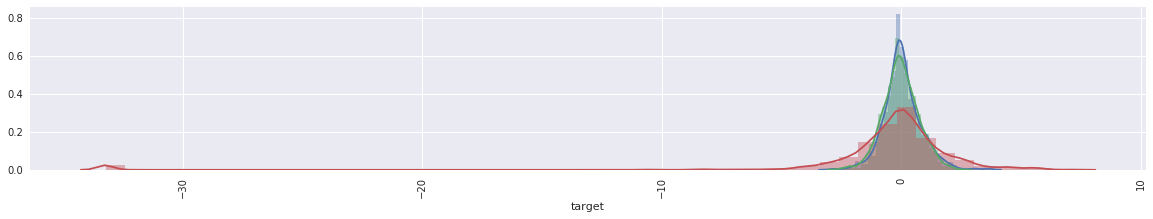

GROUP 54 | CNT: 1327 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-07-01T00:00:00.000000000 | 24
3.1680171489715576 -3.78916072845459


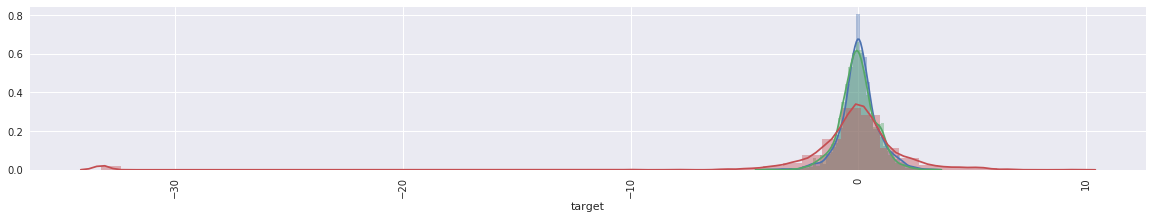

GROUP 60 | CNT: 1255 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-08-01T00:00:00.000000000 | 24
3.3885338306427 -3.9003570079803467


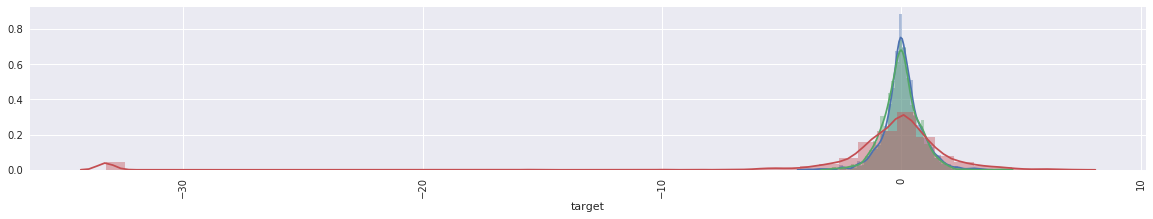

GROUP 67 | CNT: 1267 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-09-01T00:00:00.000000000 | 24
3.581521987915039 -4.144077301025391


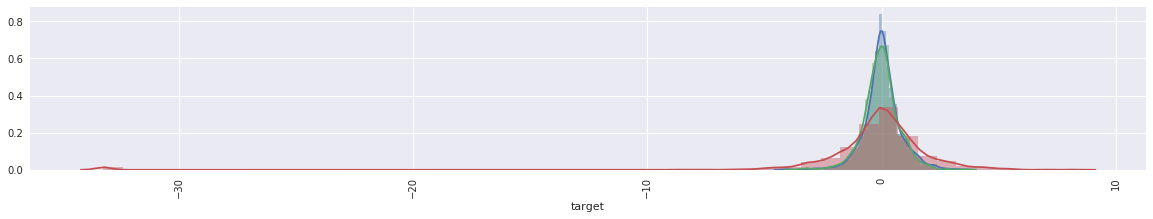

GROUP 75 | CNT: 1302 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-10-01T00:00:00.000000000 | 24
3.218679428100586 -3.9909656047821045


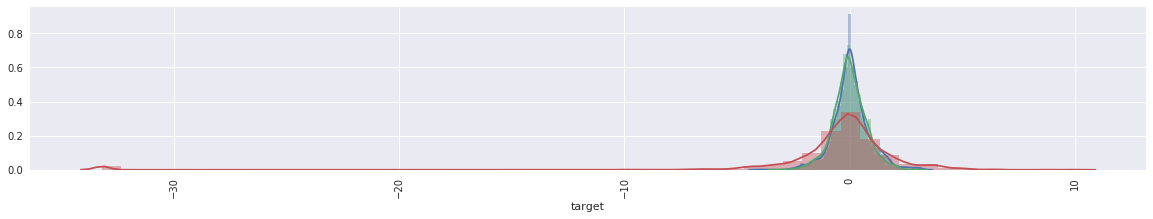

GROUP 84 | CNT: 1311 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-11-01T00:00:00.000000000 | 24
3.6241700649261475 -3.9301953315734863


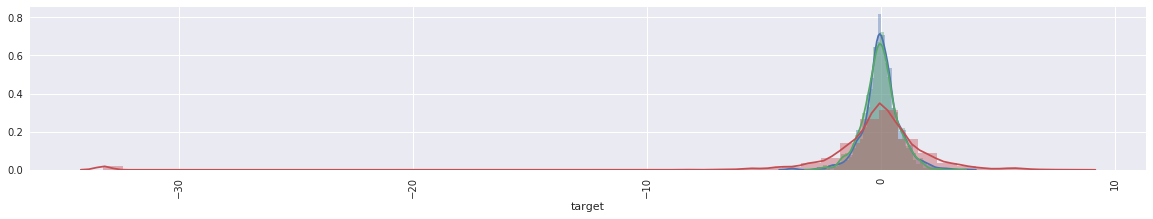

GROUP 94 | CNT: 1874 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2015-12-01T00:00:00.000000000 | 24
4.186629772186279 -4.822757244110107


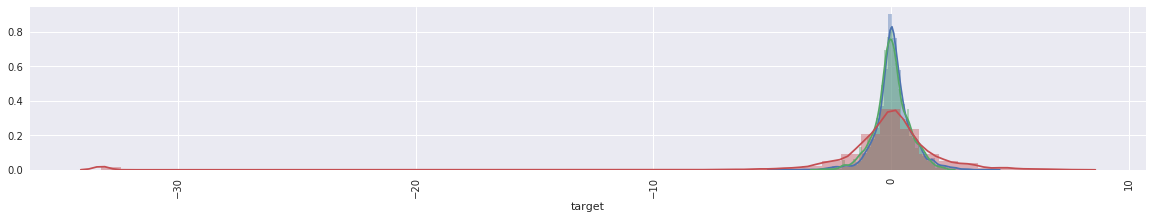

GROUP 105 | CNT: 1242 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-01-01T00:00:00.000000000 | 24
3.662684440612793 -3.143234968185425


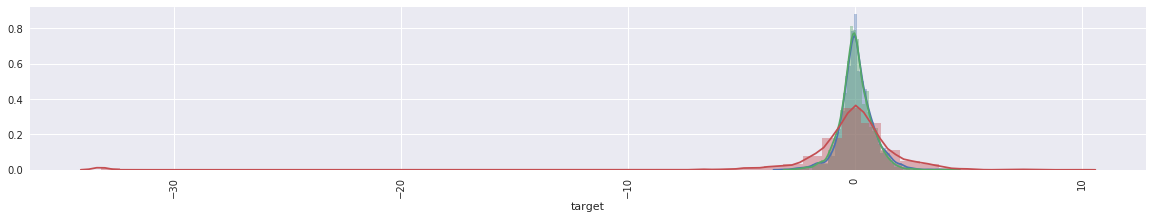

GROUP 117 | CNT: 1032 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-02-01T00:00:00.000000000 | 24
3.257335901260376 -6.184183120727539


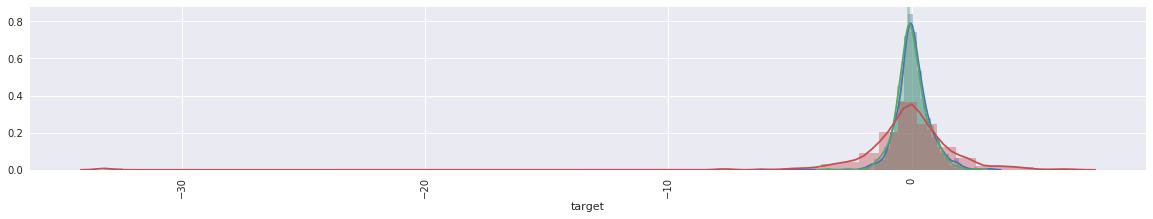

GROUP 130 | CNT: 1094 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-03-01T00:00:00.000000000 | 24
3.085864543914795 -4.538252830505371


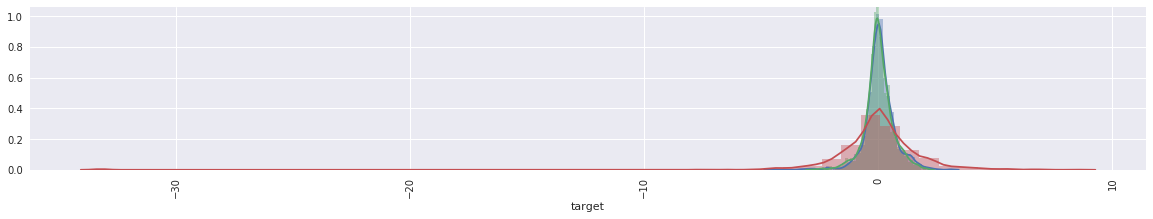

GROUP 143 | CNT: 1614 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-04-01T00:00:00.000000000 | 23
3.000361442565918 -3.4543116092681885


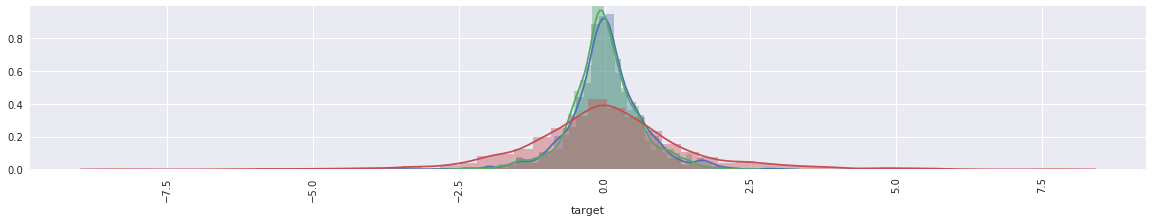

GROUP 156 | CNT: 1790 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-05-01T00:00:00.000000000 | 22
3.5004312992095947 -4.871554851531982


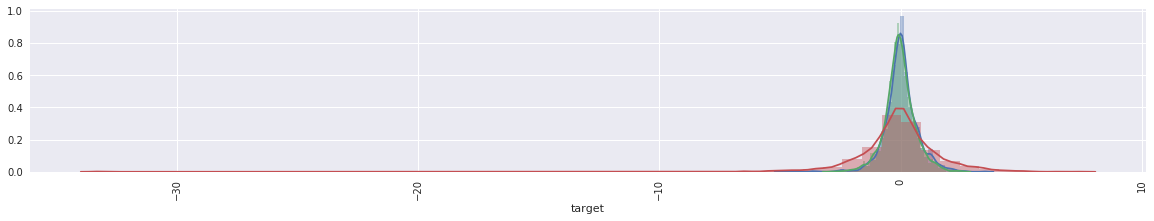

GROUP 169 | CNT: 2223 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-06-01T00:00:00.000000000 | 21
3.695448398590088 -4.0682291984558105


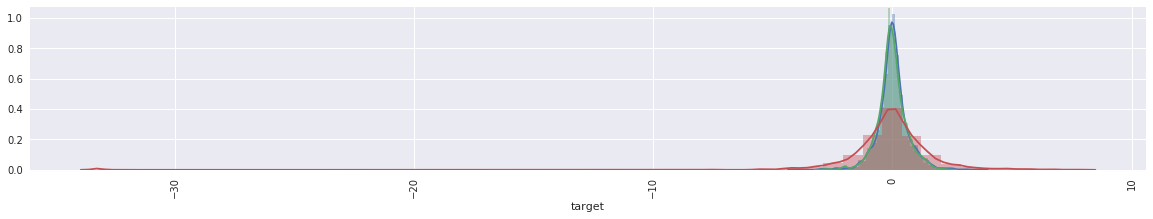

GROUP 182 | CNT: 2282 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-07-01T00:00:00.000000000 | 20
3.086874008178711 -3.8868894577026367


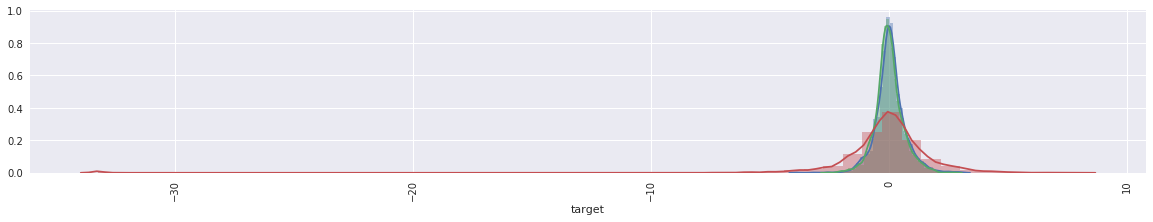

GROUP 195 | CNT: 2784 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-08-01T00:00:00.000000000 | 19
3.380953550338745 -3.8538014888763428


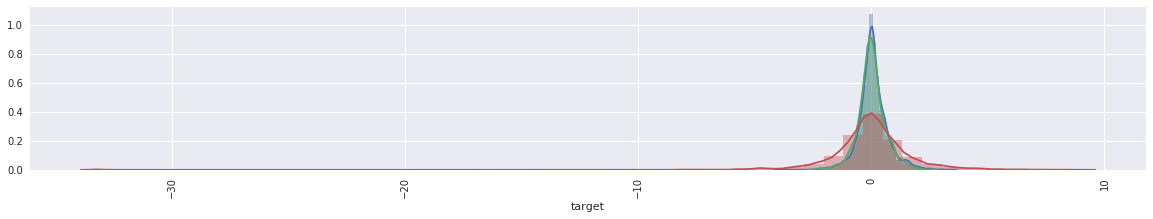

GROUP 208 | CNT: 2352 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-09-01T00:00:00.000000000 | 18
3.2036051750183105 -5.087518692016602


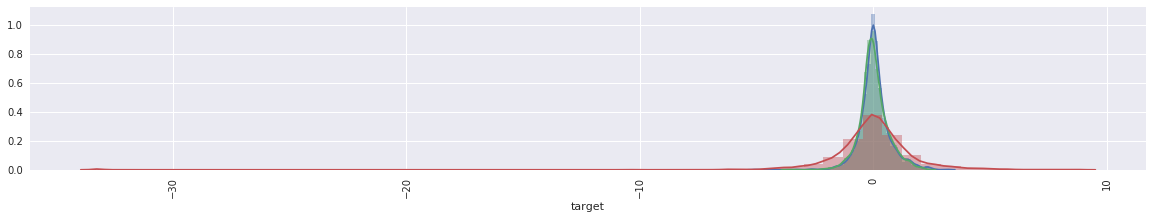

GROUP 221 | CNT: 2949 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-10-01T00:00:00.000000000 | 17
3.416673421859741 -3.638681650161743


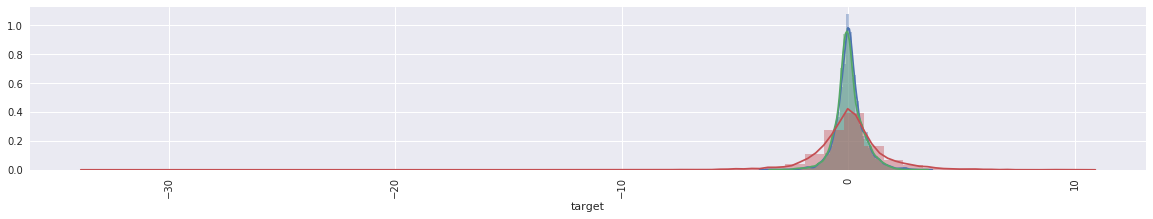

GROUP 234 | CNT: 3873 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-11-01T00:00:00.000000000 | 16
4.468296527862549 -4.21668815612793


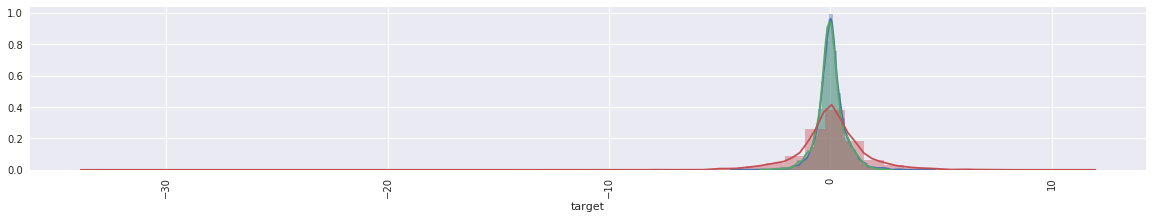

GROUP 246 | CNT: 1078 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-12-01T00:00:00.000000000 | 14
3.8811073303222656 -3.877995729446411


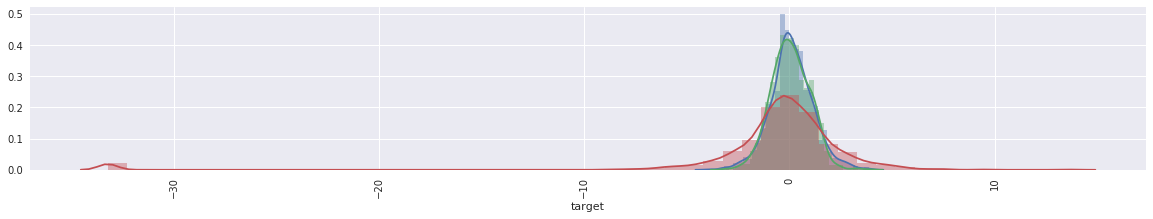

GROUP 247 | CNT: 4921 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2016-12-01T00:00:00.000000000 | 15
4.18088436126709 -3.4187862873077393


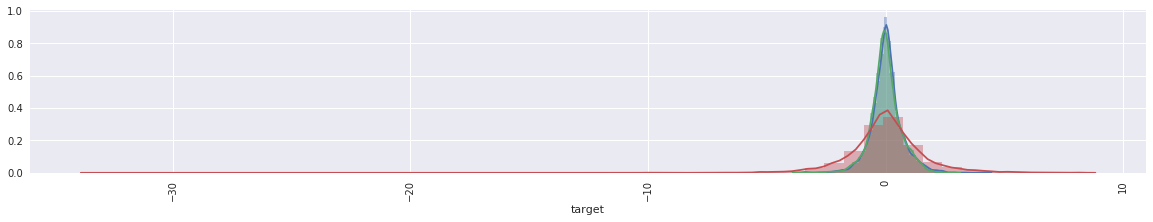

GROUP 259 | CNT: 1039 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-01-01T00:00:00.000000000 | 13
3.4838948249816895 -3.7109999656677246


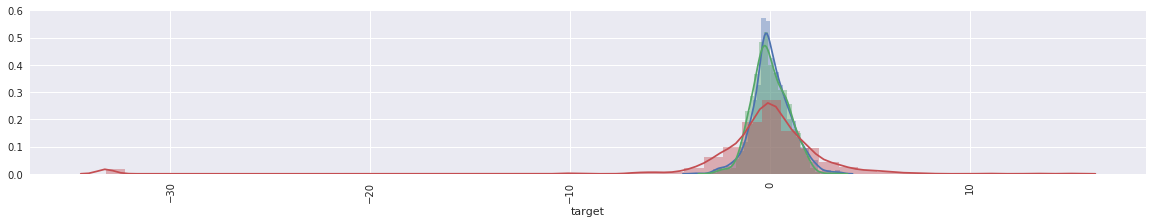

GROUP 260 | CNT: 4911 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-01-01T00:00:00.000000000 | 14
3.8086564540863037 -3.415560722351074


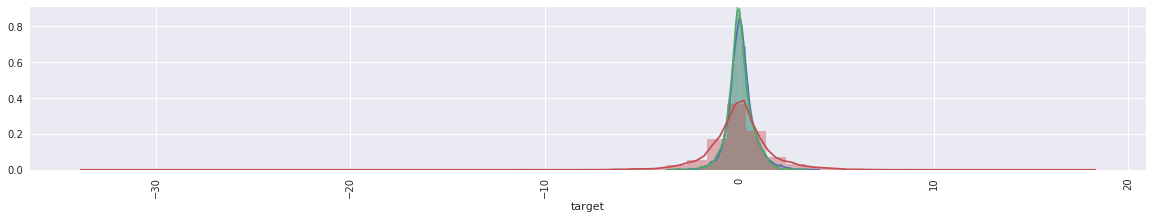

GROUP 272 | CNT: 4209 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-02-01T00:00:00.000000000 | 13
3.690058946609497 -4.768429756164551


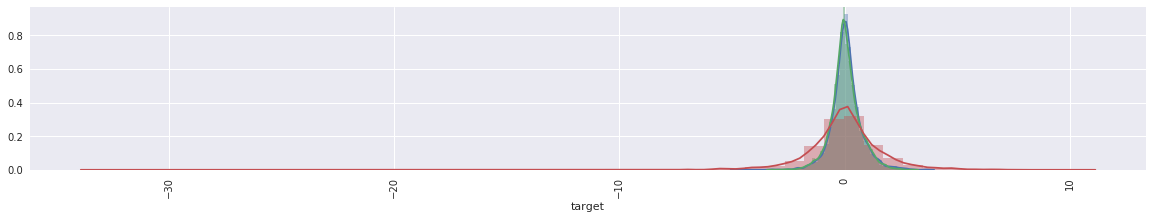

GROUP 283 | CNT: 4379 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-03-01T00:00:00.000000000 | 12
3.134601593017578 -4.137562274932861


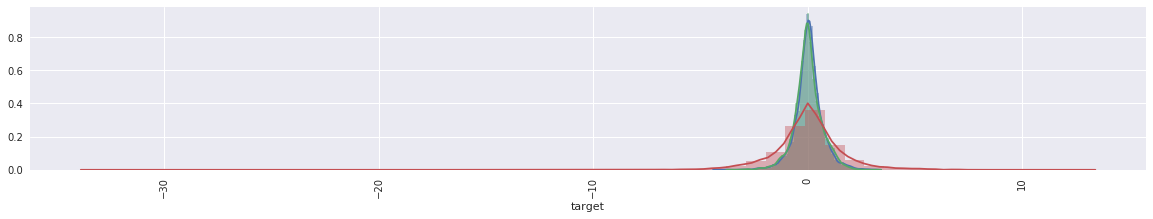

GROUP 294 | CNT: 1046 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-04-01T00:00:00.000000000 | 10
4.430365562438965 -3.2692246437072754


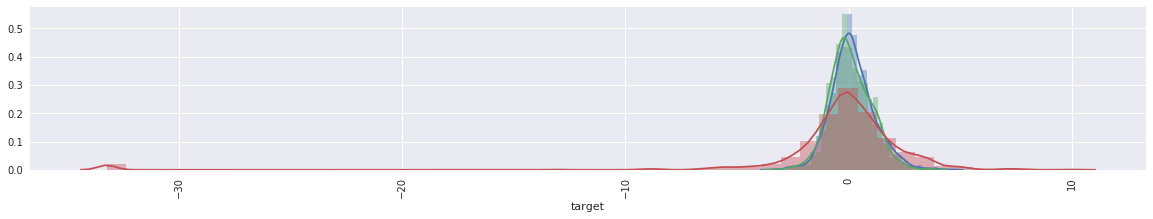

GROUP 295 | CNT: 4930 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-04-01T00:00:00.000000000 | 11
3.89986515045166 -3.663503646850586


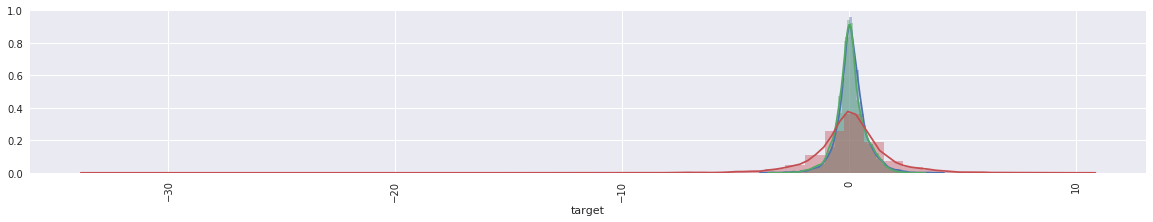

GROUP 304 | CNT: 1114 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-05-01T00:00:00.000000000 | 9
3.849302053451538 -3.9079785346984863


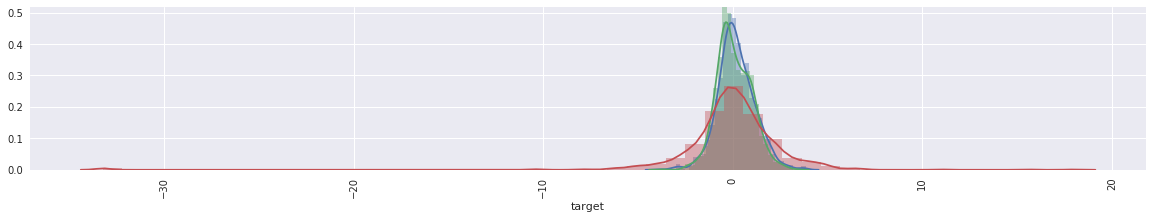

GROUP 305 | CNT: 5409 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-05-01T00:00:00.000000000 | 10
4.33754825592041 -3.323728084564209


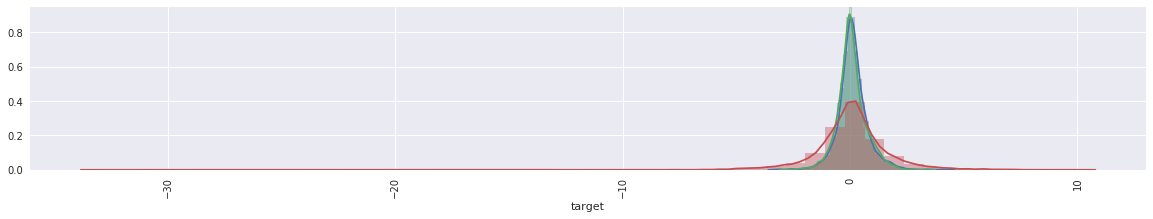

GROUP 313 | CNT: 1314 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-06-01T00:00:00.000000000 | 8
4.771407604217529 -3.6428072452545166


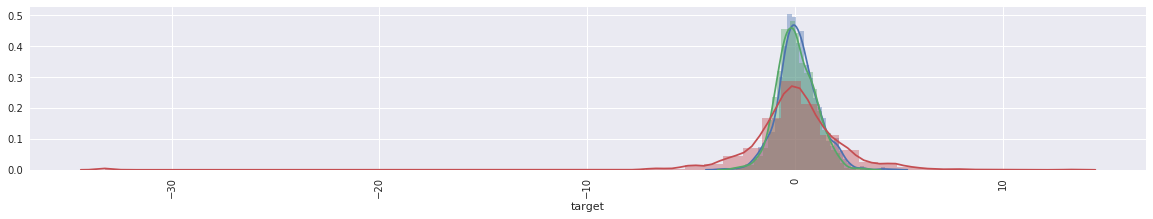

GROUP 314 | CNT: 6101 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-06-01T00:00:00.000000000 | 9
3.792065382003784 -4.699570178985596


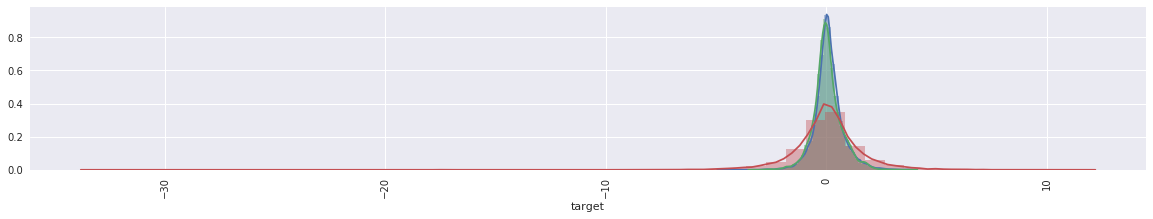

GROUP 320 | CNT: 1098 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-07-01T00:00:00.000000000 | 6
4.945271015167236 -4.403594017028809


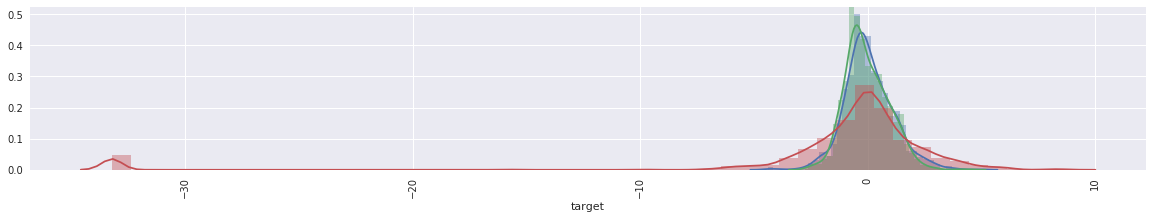

GROUP 321 | CNT: 1701 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-07-01T00:00:00.000000000 | 7
3.99507474899292 -3.0966808795928955


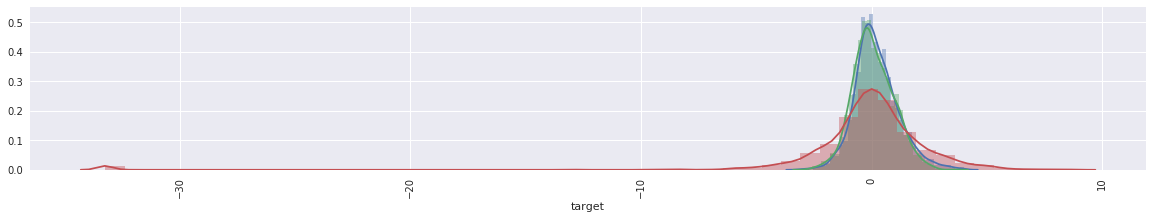

GROUP 322 | CNT: 7980 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-07-01T00:00:00.000000000 | 8
4.6688690185546875 -3.370307207107544


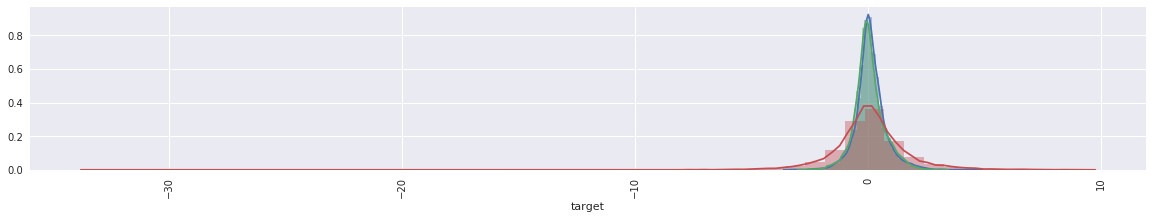

GROUP 326 | CNT: 1172 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-08-01T00:00:00.000000000 | 5
3.9720659255981445 -4.113379001617432


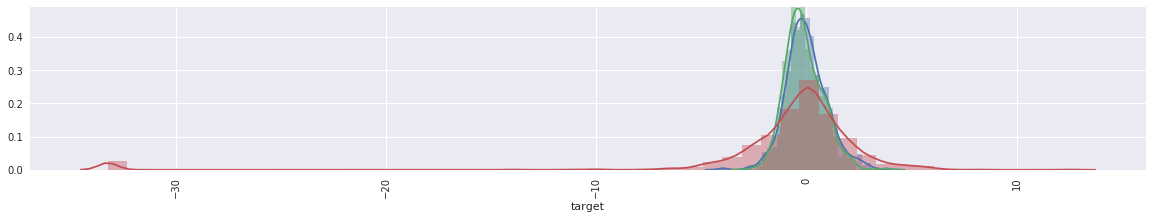

GROUP 327 | CNT: 1822 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-08-01T00:00:00.000000000 | 6
5.1783294677734375 -2.782836437225342


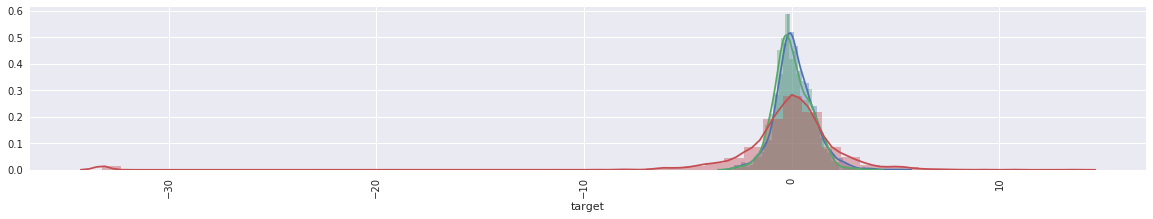

GROUP 328 | CNT: 9420 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-08-01T00:00:00.000000000 | 7
6.195021629333496 -3.3096728324890137


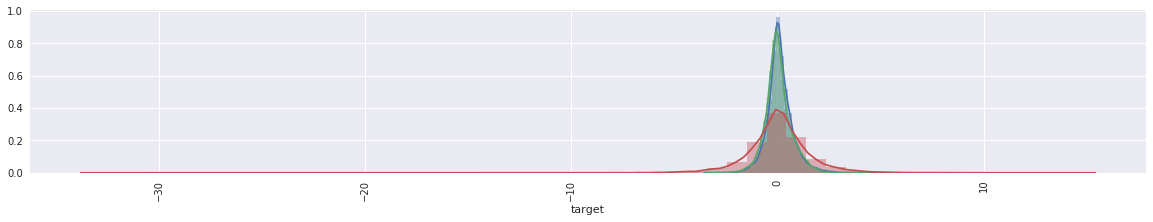

GROUP 332 | CNT: 1139 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-09-01T00:00:00.000000000 | 4
4.411877155303955 -3.1071765422821045


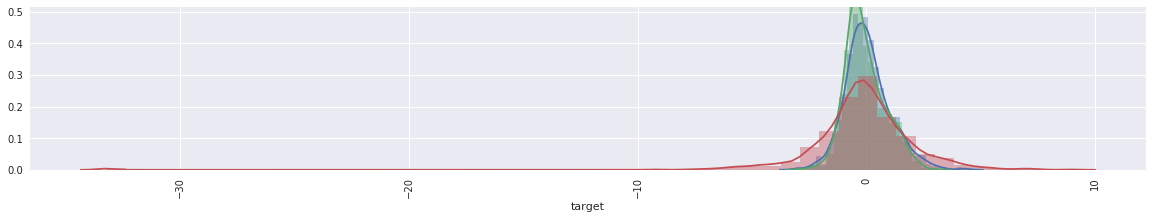

GROUP 333 | CNT: 2036 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-09-01T00:00:00.000000000 | 5
4.60435152053833 -3.7753870487213135


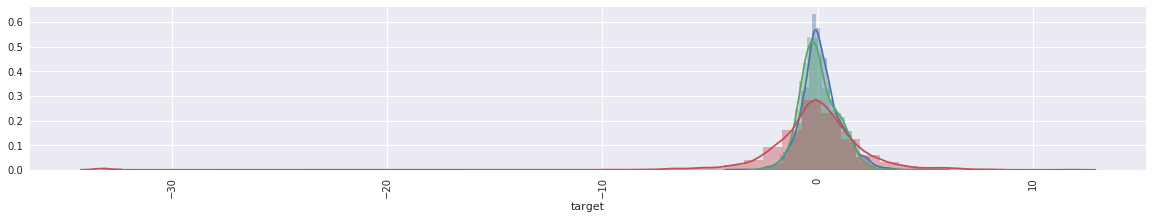

GROUP 334 | CNT: 10105 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-09-01T00:00:00.000000000 | 6
4.079061508178711 -3.712198495864868


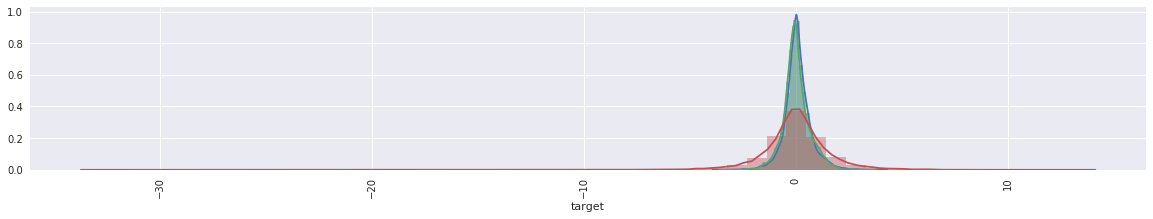

GROUP 337 | CNT: 1960 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-10-01T00:00:00.000000000 | 4
3.8244972229003906 -3.1787936687469482


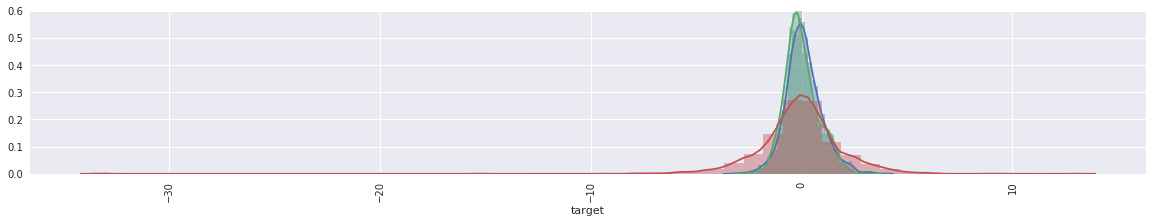

GROUP 338 | CNT: 10759 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-10-01T00:00:00.000000000 | 5
4.667070388793945 -4.332655906677246


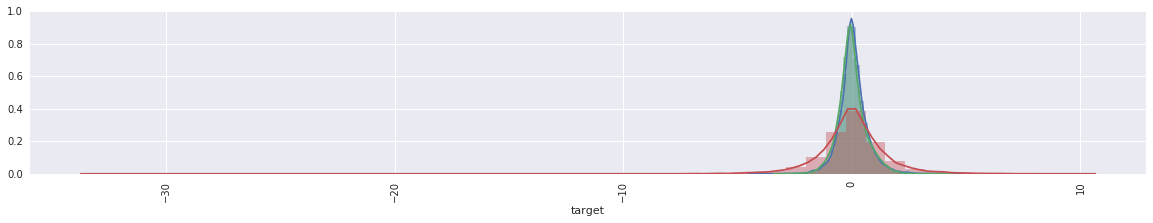

GROUP 341 | CNT: 1538 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-11-01T00:00:00.000000000 | 3
3.3798635005950928 -3.0245208740234375


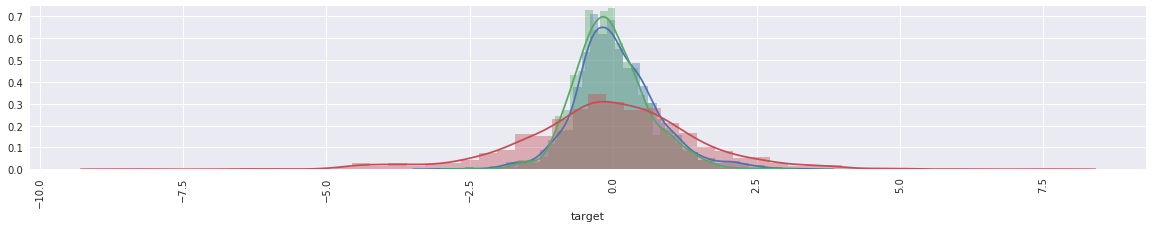

GROUP 342 | CNT: 11166 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-11-01T00:00:00.000000000 | 4
3.801643133163452 -4.50281286239624


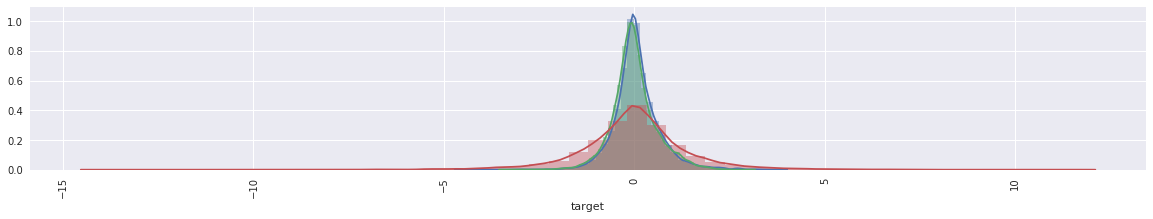

GROUP 345 | CNT: 9939 | OUTLIER: 0 | OUT_RATIO: 0.0 | 2017-12-01T00:00:00.000000000 | 3
5.740657806396484 -3.5411102771759033


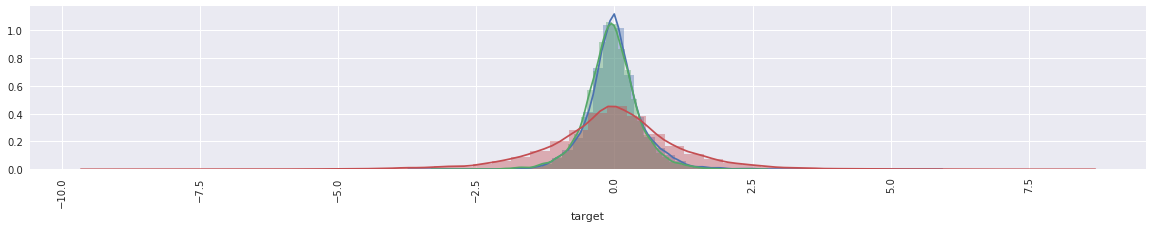

In [4]:
col_term = 'hist_regist_term'
target = 'target'
train_test = utils.read_df_pkl('../input/base_term0*')
fam = 'first_active_month'
fam_term = train_test[[fam, col_term]].drop_duplicates().sort_values(by=[fam, col_term])
fam_term.reset_index(drop=True, inplace=True)
fam_term['group'] = np.arange(len(fam_term))+1
train_test = train_test.merge(fam_term, on=[fam, col_term], how='inner')
train = train_test[~train_test[target].isnull()].set_index(key)

# train['pred'] = utils.read_pkl_gzip('../stack/0207_200_stack_lgb_lr0.01_235feats_10seed_70leaves_iter1870_OUT0_CV1-5500865669760113_LB.gz').set_index(key)['pred_mean']
train['pred'] = utils.read_pkl_gzip('../out_ensemble/0211_020_elo_NN_stack_E1_linear1_235feat_const1_lr0.001_batch128_epoch30_CV1.5006922746209812.gz').set_index(key)['prediction']
train['pred_2'] = utils.read_pkl_gzip('../stack/0207_200_stack_lgb_lr0.01_235feats_10seed_70leaves_iter1870_OUT0_CV1-5500865669760113_LB.gz').set_index(key)['pred_mean']
target = 'pred'

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# term_list = sorted(list(df_train['hist_regist_term'].value_counts().index))
df = train

group_list = sorted(list(train['group'].value_counts().index))

for i in group_list:
    tmp = df[df['group']==i]
    if len(tmp)<1000:
        continue
    out_cnt = len(tmp[tmp[target]<-30])
    cnt = len(tmp)
    
    print(f"GROUP {i} | CNT: {cnt} | OUTLIER: {out_cnt} | OUT_RATIO: {np.round(out_cnt/cnt, 3)} | {tmp[fam].values[0]} | {tmp[col_term].values[0]}")
    print(tmp[target].max(), tmp[target].min())
    plt.figure(figsize=(20, 3))
    sns.distplot(a=tmp['pred'].dropna())
    sns.distplot(a=tmp['pred_2'].dropna())
    sns.distplot(a=tmp['target'])
    plt.xticks(rotation=90)
    plt.show()